In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.ndimage.filters import gaussian_filter
import matplotlib.dates as mdates

In [2]:
from google.colab import files
import io
uploaded = files.upload()
nasdoc = pd.read_csv(io.StringIO(uploaded['^IXIC.csv'].decode('utf-8')))
#sunspot = pd.read_csv('C:\\Users\\zoo\\Documents\\data\\sunspot.csv')

Saving ^IXIC.csv to ^IXIC.csv


In [3]:
nasdoc

,Date,Close
0,2019-07-29,8293.330078
1,2019-07-30,8273.610352
2,2019-07-31,8175.419922
3,2019-08-01,8111.120117
4,2019-08-02,8004.069824
...,...,...
247,2020-07-21,10680.360352
248,2020-07-22,10706.129883
249,2020-07-23,10461.419922
250,2020-07-24,10363.179688


In [4]:
nasdoc['rt'] = np.log(nasdoc['Close'])- np.log(nasdoc['Close']).shift()

In [5]:
nasdoc['rt2'] = nasdoc['rt'].shift(-1)

In [6]:
nasdoc = nasdoc.dropna()
print(nasdoc)

           Date         Close        rt       rt2
1    2019-07-30   8273.610352 -0.002381 -0.011939
2    2019-07-31   8175.419922 -0.011939 -0.007896
3    2019-08-01   8111.120117 -0.007896 -0.013286
4    2019-08-02   8004.069824 -0.013286 -0.035354
5    2019-08-05   7726.040039 -0.035354  0.013784
..          ...           ...       ...       ...
246  2020-07-20  10767.089844  0.024815 -0.008088
247  2020-07-21  10680.360352 -0.008088  0.002410
248  2020-07-22  10706.129883  0.002410 -0.023122
249  2020-07-23  10461.419922 -0.023122 -0.009435
250  2020-07-24  10363.179688 -0.009435  0.016564

[250 rows x 4 columns]


In [7]:
nasdoc2 = nasdoc.drop(['Date', 'Close', 'rt2'], axis = 1)

In [8]:
nasdoc2

,rt
1,-0.002381
2,-0.011939
3,-0.007896
4,-0.013286
5,-0.035354
...,...
246,0.024815
247,-0.008088
248,0.002410
249,-0.023122


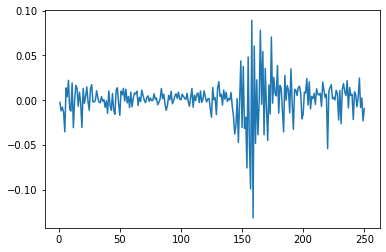

In [9]:
plt.plot(nasdoc2['rt'])
#print(nasdoc2.shape)

In [10]:
def create_dataset(dataset, lookback):
  dataX, dataY = [],[]
  for i in range(len(dataset) - (look_back + 1)):
    a = dataset[i:(i+look_back + 1)]
    dataX.append(a * a)
    dataY.append(dataset[i+look_back + 1] * dataset[i+look_back + 1])
  return np.array(dataX), np.array(dataY)

In [44]:
np.random.seed(1)
scaler = MinMaxScaler(feature_range=(0, 1))
nasdoc2 = scaler.fit_transform(nasdoc2)
type(nasdoc2)

numpy.ndarray

In [12]:
split = 0.7
dataset = nasdoc2
train_size = int(len(dataset)*split)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(nasdoc2)]

In [41]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX[0:3])
print(trainY[0:3])
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], look_back))
#testX = np.reshape(testX, (testX.shape[1], trainX.shape[0], look_back))

[[[0.34180344]
  [0.29306829]]

 [[0.29306829]
  [0.31322417]]

 [[0.31322417]
  [0.28650177]]]
[[0.31322417]
 [0.28650177]
 [0.18951309]]
(173, 2, 1)
(173, 1)
(73, 2, 1)
(73, 1)


#LSTM

In [14]:
model=Sequential()
model.add(LSTM(10, input_shape=(look_back + 1, 1)))
model.add(Dense(6))
model.add(Dense(4))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 579
Trainable params: 579
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.callbacks import EarlyStopping 

model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mse'])
early_stopping = EarlyStopping(monitor = 'loss', patience = 10, mode = 'min')
model.fit(trainX, trainY, epochs = 400, batch_size = 1, verbose = 2, callbacks = [early_stopping])

Epoch 1/400
 - 3s - loss: 0.1236 - mse: 0.0340
Epoch 2/400
 - 1s - loss: 0.0739 - mse: 0.0153
Epoch 3/400
 - 1s - loss: 0.0731 - mse: 0.0149
Epoch 4/400
 - 1s - loss: 0.0710 - mse: 0.0145
Epoch 5/400
 - 1s - loss: 0.0719 - mse: 0.0146
Epoch 6/400
 - 1s - loss: 0.0722 - mse: 0.0139
Epoch 7/400
 - 1s - loss: 0.0708 - mse: 0.0141
Epoch 8/400
 - 1s - loss: 0.0698 - mse: 0.0134
Epoch 9/400
 - 1s - loss: 0.0697 - mse: 0.0136
Epoch 10/400
 - 1s - loss: 0.0685 - mse: 0.0130
Epoch 11/400
 - 1s - loss: 0.0712 - mse: 0.0137
Epoch 12/400
 - 1s - loss: 0.0679 - mse: 0.0128
Epoch 13/400
 - 1s - loss: 0.0701 - mse: 0.0128
Epoch 14/400
 - 1s - loss: 0.0669 - mse: 0.0123
Epoch 15/400
 - 1s - loss: 0.0666 - mse: 0.0126
Epoch 16/400
 - 1s - loss: 0.0671 - mse: 0.0125
Epoch 17/400
 - 1s - loss: 0.0685 - mse: 0.0127
Epoch 18/400
 - 1s - loss: 0.0668 - mse: 0.0126
Epoch 19/400
 - 1s - loss: 0.0663 - mse: 0.0124
Epoch 20/400
 - 1s - loss: 0.0638 - mse: 0.0121
Epoch 21/400
 - 1s - loss: 0.0660 - mse: 0.0125
E

In [16]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform(trainY)

test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(testY)

train_error = mean_absolute_error(train_predict, trainY)
print('Train MAE: %.3f' % train_error)

test_error = mean_absolute_error(test_predict, testY)
print('Test MAE: %.3f' % test_error)

Train MAE: 0.014
Test MAE: 0.016


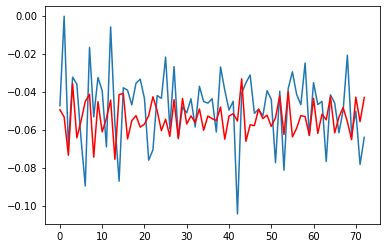

In [17]:
plt.plot(testY[0:100])
plt.plot(test_predict[0:100], color='red')
plt.show()

# RNN

In [18]:
model=Sequential()
model.add(SimpleRNN(10, input_shape=(look_back + 1, 1)))
model.add(Dense(6))
model.add(Dense(4))
model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 219
Trainable params: 219
Non-trainable params: 0
_________________________________________________________________


In [19]:
from keras.callbacks import EarlyStopping 

model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mse'])
early_stopping = EarlyStopping(monitor = 'loss', patience = 10, mode = 'min')
model.fit(trainX, trainY, epochs = 400, batch_size = 1, verbose = 2, callbacks = [early_stopping])

Epoch 1/400
 - 1s - loss: 0.0523 - mse: 0.0075
Epoch 2/400
 - 1s - loss: 0.0212 - mse: 9.8014e-04
Epoch 3/400
 - 1s - loss: 0.0195 - mse: 8.2714e-04
Epoch 4/400
 - 1s - loss: 0.0195 - mse: 8.4226e-04
Epoch 5/400
 - 1s - loss: 0.0230 - mse: 9.5970e-04
Epoch 6/400
 - 1s - loss: 0.0180 - mse: 7.0555e-04
Epoch 7/400
 - 1s - loss: 0.0202 - mse: 8.7682e-04
Epoch 8/400
 - 1s - loss: 0.0212 - mse: 8.6627e-04
Epoch 9/400
 - 1s - loss: 0.0195 - mse: 8.4073e-04
Epoch 10/400
 - 1s - loss: 0.0182 - mse: 7.3741e-04
Epoch 11/400
 - 1s - loss: 0.0182 - mse: 7.5369e-04
Epoch 12/400
 - 1s - loss: 0.0193 - mse: 8.3285e-04
Epoch 13/400
 - 1s - loss: 0.0190 - mse: 7.7483e-04
Epoch 14/400
 - 1s - loss: 0.0180 - mse: 7.1251e-04
Epoch 15/400
 - 1s - loss: 0.0180 - mse: 7.1037e-04
Epoch 16/400
 - 1s - loss: 0.0196 - mse: 8.4193e-04
Epoch 17/400
 - 1s - loss: 0.0173 - mse: 7.2590e-04
Epoch 18/400
 - 1s - loss: 0.0199 - mse: 8.9613e-04
Epoch 19/400
 - 1s - loss: 0.0190 - mse: 8.2543e-04
Epoch 20/400
 - 1s - loss

Train MAE: 0.003
Test MAE: 0.003


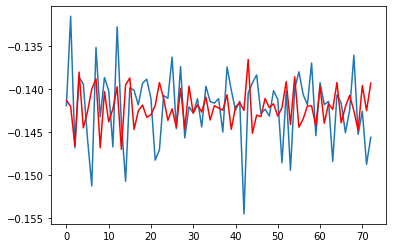

In [20]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform(trainY)

test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(testY)

train_error = mean_absolute_error(train_predict, trainY)
print('Train MAE: %.3f' % train_error)

test_error = mean_absolute_error(test_predict, testY)
print('Test MAE: %.3f' % test_error)

plt.plot(testY[0:100])
plt.plot(test_predict[0:100], color='red')
plt.show()

# Bidirectional

In [34]:
from keras.layers import Bidirectional

model=Sequential()
model.add(Bidirectional(LSTM(10), input_shape=(look_back + 1, 1)))
model.add(Dense(6))
model.add(Dense(4))
model.add(Dense(1))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 20)                960       
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 126       
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 5         
Total params: 1,119
Trainable params: 1,119
Non-trainable params: 0
_________________________________________________________________


In [35]:
from keras.callbacks import EarlyStopping 

model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mse'])
early_stopping = EarlyStopping(monitor = 'loss', patience = 10, mode = 'min')
model.fit(trainX, trainY, epochs = 400, batch_size = 1, verbose = 2, callbacks = [early_stopping])

Epoch 1/400
 - 2s - loss: 0.0138 - mse: 3.8744e-04
Epoch 2/400
 - 2s - loss: 0.0079 - mse: 1.0636e-04
Epoch 3/400
 - 2s - loss: 0.0042 - mse: 2.6832e-05
Epoch 4/400
 - 2s - loss: 0.0036 - mse: 2.0574e-05
Epoch 5/400
 - 2s - loss: 0.0022 - mse: 7.5478e-06
Epoch 6/400
 - 2s - loss: 0.0026 - mse: 1.0802e-05
Epoch 7/400
 - 2s - loss: 0.0032 - mse: 1.4318e-05
Epoch 8/400
 - 2s - loss: 0.0024 - mse: 8.7781e-06
Epoch 9/400
 - 2s - loss: 0.0016 - mse: 4.0277e-06
Epoch 10/400
 - 2s - loss: 0.0025 - mse: 9.0392e-06
Epoch 11/400
 - 2s - loss: 0.0022 - mse: 7.3778e-06
Epoch 12/400
 - 2s - loss: 0.0019 - mse: 5.5439e-06
Epoch 13/400
 - 2s - loss: 0.0019 - mse: 4.8338e-06
Epoch 14/400
 - 2s - loss: 0.0015 - mse: 3.7514e-06
Epoch 15/400
 - 2s - loss: 0.0019 - mse: 5.7374e-06
Epoch 16/400
 - 2s - loss: 0.0018 - mse: 5.1061e-06
Epoch 17/400
 - 2s - loss: 0.0021 - mse: 6.7314e-06
Epoch 18/400
 - 2s - loss: 0.0015 - mse: 4.2074e-06
Epoch 19/400
 - 2s - loss: 0.0014 - mse: 2.8871e-06
Epoch 20/400
 - 2s - 

Train MAE: 0.000
Test MAE: 0.000


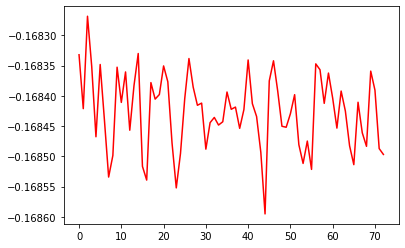

In [39]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform(trainY)

test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(testY)

train_error = mean_absolute_error(train_predict, trainY)
print('Train MAE: %.3f' % train_error)

test_error = mean_absolute_error(test_predict, testY)
print('Test MAE: %.3f' % test_error)

#plt.plot(testY[0:100])
plt.plot(test_predict[0:100], color='red')
#plt.show()

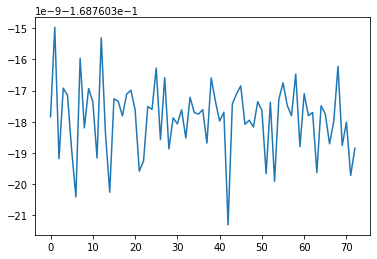

In [40]:
plt.plot(testY[0:100])